In [3]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import nltk
from gensim.utils import simple_preprocess
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

#nltk.download('stopwords')
#nltk.download('wordnet')


In [11]:
# Load the data
news_df = pd.read_csv('us_equities_news_dataset.csv') 
news_df['content'] = news_df['content'].fillna('')
texts = news_df['content'].tolist()

In [12]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = simple_preprocess(text)  # Tokenization and lowercasing
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

In [3]:
#Filter the news dataset for the articles that contain knowledge about NVidia.
#These can be abbravations for Nvidia or just the name so this list contains words I'm searchinmg for in filtering the dataset
#by checking if all content or title contain "nvidia_terms" list.
nvidia_terms = [
    'Nvidia', 'NVDA', 'N V D I A', 'Nvidia Corporation', 'NVIDIA Corp', 
    'NVIDIA GPUs', 'NVIDIA graphics', 'NVIDIA chip', 'NVIDIA cards', 
    'Nvidia GeForce', 'GeForce', 'Nvidia Quadro', 'NVIDIA AI', 
    'NVIDIA Tegra', 'Nvidia Drive', 'Nvidia RTX', 'RTX', 
    'NVIDIA DGX', 'NVIDIA Shield', 'CUDA', 'NVIDIA Jetson', 
    'NVIDIA Omniverse', 'NVIDIA Hopper', 'NVIDIA architecture',
    'Nvidia hardware', 'Nvidia software', 'NVIDIA tech'
]

#Second filtering is applied to tickers to find the some companies that can affect the price. 
#My research shows AMD and Intel are the biggest competitors for Nvidia so I'm also including articles with ticker = 'AMD,INTC'
filtered_news_df = news_df[
    (news_df['title'].str.contains('|'.join(nvidia_terms), case=False, na=False)) |
    (news_df['content'].str.contains('|'.join(nvidia_terms), case=False, na=False)) |
    (news_df['ticker'].isin(['AMD', 'INTC']))  # Filter for AMD and Intel tickers
]

# Display the filtered DataFrame with Nvidia, AMD, and Intel related articles
print(filtered_news_df[['ticker', 'title', 'release_date']])
filtered_news_df = filtered_news_df.drop_duplicates()

       ticker                                              title release_date
24        NIO  A Central Bank War Just Started And Its Good F...   2019-03-07
32        NIO         6 Stocks To Watch  Nivida Could Be Falling   2019-03-06
57        NIO  Stocks   Dow Drops Nearly 400 Points as Apple ...   2018-11-19
78       UBER  The Zacks Analyst Blog Highlights  Advanced Mi...   2020-01-12
82       UBER                     The Best Of CES 2020  Revised    2020-01-16
...       ...                                                ...          ...
221198    AMD  7 Tech Stocks With SMA50 Above SMA200 And High...   2012-12-07
221202    AMD                           Deceased Rubber Felines    2012-11-25
221229    PFE          Durata Therapeutics  DRTX  Pre IPO Report   2012-07-19
221468      T  Zacks com Featured Highlights  AT T  Nu Skin E...   2016-07-21
221471      T  5 Dividend Growth Stocks To Sail Through Uncer...   2016-07-20

[7256 rows x 3 columns]


In [30]:
filtered_news_df = pd.read_csv('filtered_news_df.csv')

In [4]:
#filtered_news_df.to_csv('filtered_news_df.csv',index=False)

In [31]:
filtered_news_df['processed_text'] = filtered_news_df['content'].fillna('').apply(preprocess)

In [32]:
filtered_news_df['processed_text'].head(5)

0    [ecb, effect, move, euro, huge, falling, pip, ...
1    [stock, watch, march, trading, session, stock,...
2    [investing, com, rout, apple, facebook, nasdaq...
3    [immediate, releasechicago, il, january, zacks...
4    [company, bringing, innovation, ce, jan, get, ...
Name: processed_text, dtype: object

In [33]:
filtered_news_df.columns

Index(['id', 'ticker', 'title', 'category', 'content', 'release_date',
       'provider', 'url', 'article_id', 'processed_text'],
      dtype='object')

In [23]:
#Join all preprocessed text for FLSA-W
all_tokens = sum(filtered_news_df['processed_text'], [])  
merged_string = ' '.join(all_tokens)

In [34]:
# Convert each list of tokens in 'processed_text' to a single string
filtered_news_df['processed_text'] = filtered_news_df['processed_text'].apply(lambda x: ' '.join(x))

In [35]:
filtered_news_df.to_csv('filtered_processed_df.csv',index=False)

In [36]:
# Now apply TF-IDF
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(filtered_news_df['processed_text'])

Topic 1:  rose rank growth billion nvidia percent estimate revenue quarter zacks
Topic 2:  buy esp growth million consensus revenue rank estimate quarter zacks
Topic 3:  start range highest volume gmt day seven lowest nvidia traded
Topic 4:  bank data amd china qualcomm apple reuters chip said percent
Topic 5:  reported estimate consensus billion cent gaap million revenue quarter percent


In [41]:
n_topics = 5
svd_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_matrix = svd_model.fit_transform(tfidf_matrix)

In [42]:
# Display Topics
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(svd_model.components_):
    print(f"Topic {idx + 1}: ", " ".join([terms[i] for i in topic.argsort()[-10:]]))

Topic 1:  rose rank growth billion nvidia percent estimate revenue quarter zacks
Topic 2:  buy esp growth million consensus revenue rank estimate quarter zacks
Topic 3:  start range highest volume gmt day seven lowest nvidia traded
Topic 4:  bank data amd china qualcomm apple reuters chip said percent
Topic 5:  reported estimate consensus billion cent gaap million revenue quarter percent


Summary of Each Topic’s Role
Topic 1 and Topic 2 focus on financial performance and growth metrics specifically related to Nvidia, with one leaning more towards growth metrics (Topic 1) and the other on analyst recommendations and predictions (Topic 2).
Topic 3 covers stock trading activity and market behavior, providing insights into Nvidia’s stock price movements and trading volumes.
Topic 4 broadens the view to include industry news and external factors affecting Nvidia and its competitors, with attention to market dynamics influenced by major tech players and geopolitical events.
Topic 5 zeroes in on earnings reports and revenue—the financial backbone of Nvidia’s quarterly performance.

Generated by chatgpt for the topics above

In [37]:
def calculate_explained_variance(tfidf_matrix, topic_range):
    explained_variances = []
    models = {}
    for n_topics in topic_range:
        svd_model = TruncatedSVD(n_components=n_topics, random_state=42)
        svd_model.fit(tfidf_matrix)
        explained_variances.append(svd_model.explained_variance_ratio_.sum())
        
        # Save the model in memory
        models[n_topics] = svd_model
    
    return explained_variances, models

In [43]:
topic_range = range(2, 11)
explained_variances, models = calculate_explained_variance(tfidf_matrix, topic_range)

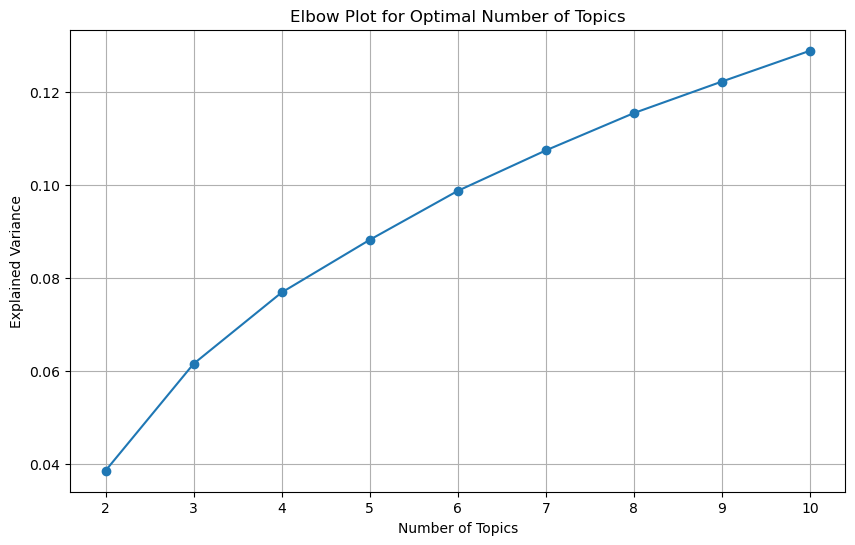

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(topic_range, explained_variances, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Explained Variance")
plt.title("Elbow Plot for Optimal Number of Topics")
plt.xticks(topic_range)
plt.grid(True)
plt.show()

In [2]:
filtered_processed_df = pd.read_csv('filtered_processed_df.csv')

In [3]:
# Now apply TF-IDF
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
tfidf_matrix2 = vectorizer.fit_transform(filtered_processed_df['processed_text'])

In [5]:
n_topics = 8
svd_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_matrix = svd_model.fit_transform(tfidf_matrix2)

In [6]:
# Display Topics
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(svd_model.components_):
    print(f"Topic {idx + 1}: ", " ".join([terms[i] for i in topic.argsort()[-10:]]))

Topic 1:  rose rank growth billion nvidia percent estimate revenue quarter zacks
Topic 2:  buy esp growth million consensus revenue rank estimate quarter zacks
Topic 3:  start range highest volume gmt day seven lowest nvidia traded
Topic 4:  bank amd data china qualcomm apple reuters chip said percent
Topic 5:  reported estimate consensus billion cent gaap million revenue quarter percent
Topic 6:  said billion driving apple million revenue qualcomm nvidia chip amd
Topic 7:  ratio rank driving industry close investment performer settle zacks percent
Topic 8:  price radeon processor advanced gpu gaming nvidia graphic micro amd


In [9]:
new_df = pd.read_csv('data_cleaned.csv')

In [10]:
processed_texts_filtered = new_df['content']

In [11]:
# Now apply TF-IDF
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
tfidf_matrix2 = vectorizer.fit_transform(processed_texts_filtered)

In [12]:
n_topics = 8
svd_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_matrix = svd_model.fit_transform(tfidf_matrix2)

In [13]:
# Display Topics
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(svd_model.components_):
    print(f"Topic {idx + 1}: ", " ".join([terms[i] for i in topic.argsort()[-10:]]))

Topic 1:  share past day consensus estimate revenues rank million trade traded
Topic 2:  investing start session volume highest exchange lowest seven gmt traded
Topic 3:  futures week dow fell trade close rose index points percent
Topic 4:  non close consensus rose performers cents points gaap revenues million
Topic 5:  autonomous graphics gaming self chips driving said intel amd percent
Topic 6:  thursday forecast reuters week analysts sales said million revenue percent
Topic 7:  pc ryzen micro gpus intel radeon graphics gaming gpu amd
Topic 8:  recommendation advice analyst securities settle rose performers research investment percent
